In [1]:
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

import blackjax

from rhmcjax.targets.gaussians_on_circle import GaussiansOnCircle

### Reflection Hamiltonian Monte Carlo (RHMC) with [`blackjax`](https://blackjax-devs.github.io/blackjax/index.html)
The following code is inspired by parts of the [`blackjax` tutorial](https://blackjax-devs.github.io/blackjax/examples/quickstart.html). Oftentimes, the goal of HMC is to infer the unknown parameters of some target distribution based on samples from this target. However, this is different in physics where the target distribution is analytically available and the goal is to efficiently draw a vast amount of samples. While HMC can be utilized for this purpose, it has to be adapted to the physics specific setting that we are interested in: High Energy Physics (HEP). Here, the distributions (called matrix elements) provided by some approximation of Quantum Field Theory have one specific property. They are restricted to a constrained space due to mass and momentum conservation. Outside of this phase space boundary, a decay is physically not possible.

This basic property stands in contrast to one of the fundamental assumptions of MCMC: "MCMC algorithms assume that the distribution is defined on an UNCONSTRAINED Euclidean space."
HMC was extended from an unconstrained to a constrained space in the paper [Reflection, Refraction, and Hamiltonian Monte Carlo](https://papers.nips.cc/paper_files/paper/2015/hash/8303a79b1e19a194f1875981be5bdb6f-Abstract.html) and is implemented in this package for distributions with support on the unit hypercube.

To show its functionality, we need a distribution only defined on $[0,1]^2$:

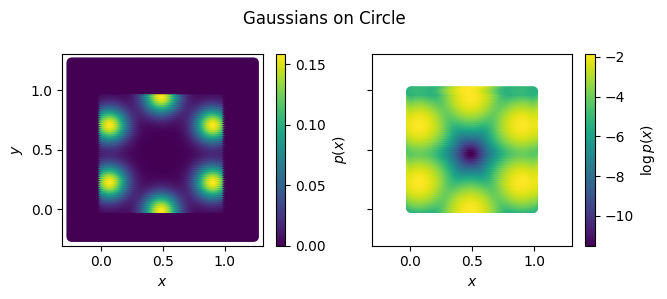

In [2]:
key = jax.random.key(seed=42)

constrained_target = GaussiansOnCircle(restrict_to_unit_hypercube=True)
x = jnp.linspace(-0.25, 1.25, 100)[1:-1]
grid_unit = jnp.dstack(jnp.meshgrid(x, x))
grid_unit = grid_unit.reshape([-1, 2])
p_vals = constrained_target.prob(grid_unit)

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(7,3))
colorbar = axes[0].scatter(grid_unit[:,0], grid_unit[:,1], c=p_vals)
cbar = fig.colorbar(colorbar, ax=axes[0])
cbar.set_label(r'$p(x)$')
axes[0].set_xlabel(r'$x$')
axes[0].set_ylabel(r'$y$')

logp_vals = constrained_target.log_prob(grid_unit)
colorbar = axes[1].scatter(grid_unit[:,0], grid_unit[:,1], c=logp_vals)
cbar = fig.colorbar(colorbar, ax=axes[1])
cbar.set_label(r'$\log p(x)$')
axes[1].set_xlabel(r'$x$')
fig.suptitle('Gaussians on Circle')

plt.tight_layout()

Here, we can see immediately that the probability $p(x)$ is zero for values outside $[0,1]^2$. If we perform standard HMC as described in `hmc_example.ipynb`, each chain that steps outside the support is rejected.
In the following, we will first motivate why reflection is needed in HMC.

### Why we need reflection in HMC
We will perform standard HMC on the distribution with limited support. Therefore, we need to first set the HMC parameters and the function for running HMC.

In [3]:
inv_mass_matrix = jnp.array([0.5, 0.01])
num_integration_steps = 60
step_size = 1e-2 #1e-3

logdensity = constrained_target.log_prob
hmc = blackjax.hmc(logdensity, step_size, inv_mass_matrix, num_integration_steps)

def run_hmc(key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, key):
        state, info = kernel(key, state)
        return state, (state, info)

    keys = jax.random.split(key, num_samples)
    final_state, (states, info) = jax.lax.scan(one_step, initial_state, keys)

    return states, info

Now, we will run 10 chains subsequently with 10,000 samples each.

In [4]:
key, subkey = jax.random.split(key)
initial_positions = jax.random.uniform(subkey, shape=[10, 2])
chains = []
for init_p in initial_positions:
    initial_position = init_p.reshape([-1, 2])
    key, subkey = jax.random.split(key)
    initial_state = hmc.init(initial_position)
    state, info = run_hmc(subkey, hmc.step, initial_state, 10_000)
    chains.append(state.position[info.is_accepted].squeeze())
mcmc_chains = jnp.vstack(chains)
mcmc_chains.shape

(38218, 2)

For comparison, we run 10 chains with 10,000 samples each in the unrestricted case.

In [5]:
unconstrained_target = GaussiansOnCircle(restrict_to_unit_hypercube=False)

logdensity_unc = unconstrained_target.log_prob
hmc_unc = blackjax.hmc(logdensity_unc, step_size, inv_mass_matrix, num_integration_steps)
chains_unc = []
for init_p in initial_positions:
    initial_position = init_p.reshape([-1, 2])
    key, subkey = jax.random.split(key)
    initial_state = hmc_unc.init(initial_position)
    state, info = run_hmc(subkey, hmc_unc.step, initial_state, 10_000)
    chains_unc.append(state.position[info.is_accepted].squeeze())
mcmc_chains_unc = jnp.vstack(chains_unc)
mcmc_chains_unc.shape

(99960, 2)

To validate the samples, we can plot the histograms.

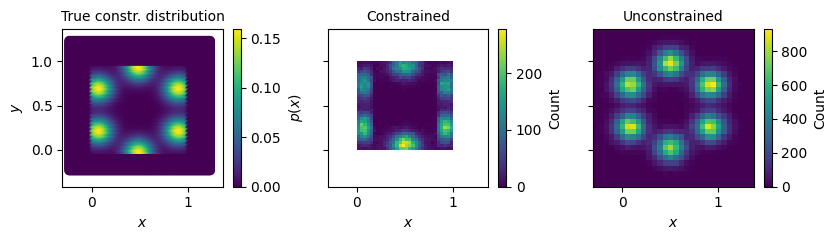

In [6]:
mcmc_chains = mcmc_chains.reshape([-1, 2])
mcmc_chains_unc = mcmc_chains_unc.reshape([-1, 2])

fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(8.5,2.5))
colorbar = axes[0].scatter(grid_unit[:,0], grid_unit[:,1], c=p_vals)
cbar = fig.colorbar(colorbar, ax=axes[0])
cbar.set_label(r'$p(x)$')
axes[0].set_xlabel(r'$x$')
axes[0].set_ylabel(r'$y$')
axes[0].set_title('True constr. distribution', fontsize=10)

h, x, y, img = axes[1].hist2d(mcmc_chains[:,0], mcmc_chains[:,1], bins=30)
cbar = fig.colorbar(img, ax=axes[1])
cbar.set_label('Count')
axes[1].set_xlabel(r'$x$')
axes[1].set_title('Constrained', fontsize=10)

h, x, y, img = axes[2].hist2d(mcmc_chains_unc[:,0], mcmc_chains_unc[:,1], bins=30)
cbar = fig.colorbar(img, ax=axes[2])
cbar.set_label('Count')
axes[2].set_xlabel(r'$x$')
axes[2].set_title('Unconstrained', fontsize=10)

plt.tight_layout()

Although the histogram of samples drawn from the distribution with constrained support looks fine, it can be observed that the maximal count is significantly less than the maximal count in the unrestricted case. 

This is confirmed by the average acceptance rates:

In [7]:
print(f'Acceptance rate of HMC on unconstrained distribution: {len(mcmc_chains_unc)/100_000 * 100:.3f}%')
print(f'Acceptance rate of HMC on constrained distribution: {len(mcmc_chains)/100_000 * 100}%')

Acceptance rate of HMC on unconstrained distribution: 99.960%
Acceptance rate of HMC on constrained distribution: 38.218%


The reason for the high rejection rate in the constrained case results from steps that move outside of the support. These steps have a probability of zero and are always rejected. If a chain ends up close to the boundary, it is likely that the next step will be proposed outside of the support and rejected. This decreases the acceptance probability and is problematic if modes are located at the boundary which is the case in HEP.

Although is problem might be mitigated with a smaller step size, it becomes increasingly important in higher dimension.
Therefore, the reflection of steps crossing the phase space boundary is introduced with Reflection HMC (RHMC).
A visualization of the reflection algorithm using the core part of the code is provided in `reflection_algorithm_in_detail.ipynb`.

In [8]:
from blackjax.mcmc.hmc import init
from rhmcjax.rhmc.rhmc import build_rhmc_kernel, reflection_velocity_verlet, rhmc

In [9]:
kernel = build_rhmc_kernel(reflection_velocity_verlet)
logdensity_fn = constrained_target.log_prob
key, subkey = jax.random.split(key)
initial_position = jax.random.uniform(subkey, shape=[2])
state = init(initial_position, logdensity_fn)
key, subkey = jax.random.split(key)
state, info = kernel(subkey, state, logdensity_fn, step_size, inv_mass_matrix, num_integration_steps)

In [10]:
logdensity = constrained_target.log_prob
rhmc_sampler = rhmc(logdensity, step_size, inv_mass_matrix, num_integration_steps)

def run_rhmc(key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, key):
        state, info = kernel(key, state)
        return state, (state, info)

    keys = jax.random.split(key, num_samples)
    final_state, (states, info) = jax.lax.scan(one_step, initial_state, keys)

    return states, info

In [11]:
key, subkey = jax.random.split(key)
initial_positions = jax.random.uniform(subkey, shape=[10, 2])
chains = []
for init_p in initial_positions:
    key, subkey = jax.random.split(key)
    initial_state = rhmc_sampler.init(init_p)
    state, info = run_rhmc(subkey, rhmc_sampler.step, initial_state, 10_000)
    chains.append(state.position[info.is_accepted].squeeze())
mcmc_chains_refl = jnp.vstack(chains)
mcmc_chains_refl.shape

(99983, 2)

To validate the obtained RHMC samples, we can plot their histogram and compare it to the previously obtained samples of HMC on the same restricted domain.

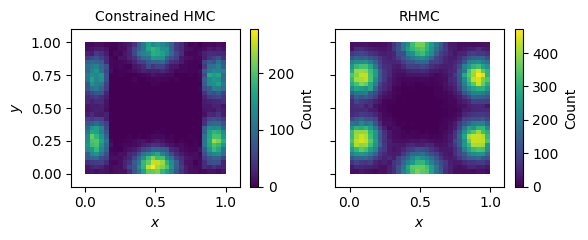

In [12]:
mcmc_chains_refl = mcmc_chains_refl.reshape([-1, 2])

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(6,2.5))

h, x, y, img = axes[0].hist2d(mcmc_chains[:,0], mcmc_chains[:,1], bins=30)
cbar = fig.colorbar(img, ax=axes[0])
cbar.set_label('Count')
axes[0].set_xlabel(r'$x$')
axes[0].set_ylabel(r'$y$')
axes[0].set_title('Constrained HMC', fontsize=10)

h, x, y, img = axes[1].hist2d(mcmc_chains_refl[:,0], mcmc_chains_refl[:,1], bins=30)
cbar = fig.colorbar(img, ax=axes[1])
cbar.set_label('Count')
axes[1].set_xlabel(r'$x$')
axes[1].set_title('RHMC', fontsize=10)
axes[1].set_xlim([-0.1, 1.1])
axes[1].set_ylim([-0.1, 1.1])
plt.tight_layout();

The RHMC histogram not only shows a more realistic distribution, but also has a higher number of samples (due to the larger values on the colorbar).
The acceptance rates reflect these qualitative changes:

In [13]:
print(f'Acceptance rate of HMC on unconstrained distribution: {len(mcmc_chains_unc)/100_000 * 100:.3f}%')
print(f'Acceptance rate of HMC on constrained distribution: {len(mcmc_chains)/100_000 * 100}%')
print(f'Acceptance rate of RHMC on constrained distribution: {len(mcmc_chains_refl)/100_000 * 100}%')

Acceptance rate of HMC on unconstrained distribution: 99.960%
Acceptance rate of HMC on constrained distribution: 38.218%
Acceptance rate of RHMC on constrained distribution: 99.983%


As a result, we can conclude that including the reflection HMC increases the acceptance rate for distributions restricted to finite domains.

### Visualization of RHMC chains
Finally, we want to visualize RHMC chains to confirm that the samples are located within the unit hypercube. For this, we save a small set of samples of a few RHMC chains and plot them in a `.gif` using `imageio`.

In [14]:
key, subkey = jax.random.split(key)
n_chains = 10
initial_positions = jax.random.uniform(subkey, shape=[n_chains, 2])
chains = []
samples_per_chain = 10
for init_p in initial_positions:
    key, subkey = jax.random.split(key)
    initial_state = rhmc_sampler.init(init_p)
    state, info = run_rhmc(subkey, rhmc_sampler.step, initial_state, samples_per_chain)
    chains.append(state.position[info.is_accepted].squeeze())
mcmc_chains_refl = jnp.vstack(chains)
mcmc_chains_refl.shape

(100, 2)

In [15]:
from matplotlib import colormaps
import numpy as np
from matplotlib.collections import LineCollection
import imageio

In [16]:
%%capture

constrained_target = GaussiansOnCircle(restrict_to_unit_hypercube=True)
x = jnp.linspace(0., 1., 100)[1:-1]
grid_unit = jnp.dstack(jnp.meshgrid(x, x))
grid_unit = grid_unit.reshape([-1, 2])
p_vals = constrained_target.prob(grid_unit)

plot_chains = n_chains
plot_samples_per_chain = samples_per_chain
col_map = colormaps['Reds']
colors = []
for c in range(plot_chains):
    colors.append([c/plot_chains]*plot_samples_per_chain)
colors = [c for sub_c in colors for c in sub_c]

def plot_step_refl(i):
    fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(4,3.5))
    # Plot distribution
    colorbar = axs.scatter(grid_unit[:,0], grid_unit[:,1], c=p_vals)
    cbar = fig.colorbar(colorbar, ax=axs)
    cbar.set_label(r'$p(x)$')
    # Plot trajectory
    x = mcmc_chains_refl[:i,0]
    y = mcmc_chains_refl[:i,1]

    points = jnp.array([x, y]).T.reshape(-1, 1, 2)
    segments = jnp.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(0,1)
    lc = LineCollection(segments, cmap=col_map, norm=norm)
    # Set the values used for colormapping
    vsl = jnp.array(colors)
    lc.set_array(vsl[:i])
    lc.set_linewidth(1.5)
    axs.add_collection(lc)
    axs.scatter(mcmc_chains_refl[:i,0], mcmc_chains_refl[:i,1], c=col_map(colors[:i]), s=10.)

    # IMPORTANT ANIMATION CODE HERE
    # Used to set constant limits
    axs.set(xlabel='$x$', ylabel='$y$', xlim=[0, 1], ylim=[0, 1])
    plt.tight_layout()

    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

kwargs_write = {'fps':5, 'quantizer':'nq'}
imageio.mimsave('../images/rhmc.gif', [plot_step_refl(i) for i in range(2, len(mcmc_chains_refl)+1)], fps=5, loop=2)